# 5.7 ELMo

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

replicating local resources


### ELMo: Embeddings from Language Models

Word embeddings such as word2vec or GloVe provides an exact meaning to words. Eventhough they provided a great improvement to many NLP task, such "constant" meaning was a major drawback of this word embeddings as the meaning of words changes based on context, and thus this wasn't the best option for Language Modelling.

For instance, after we train word2vec/Glove on a corpus we get as output one vector representation for, say the word **cell**. So even if we had a sentence like "He went to the prison **cell** with his **cell** phone to extract blood **cell** samples from inmates", where the word **cell** has different meanings based on the sentence context, these models just collapse them all into one vector for **cell** in their output [source](https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe).

Unlike most widely used word embeddings ELMo word representations are functions of the entire input sentence, instead of the single word. They are computed on top of two-layer Bidirectional Language Models (biLMs) with character convolutions, as a linear function of the internal network states. Therefore, the same word can have different word vectors under different contexts.

[Deep contextualized word representations](https://arxiv.org/pdf/1802.05365.pdf)

[Character-level Convolutional Networks](https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)

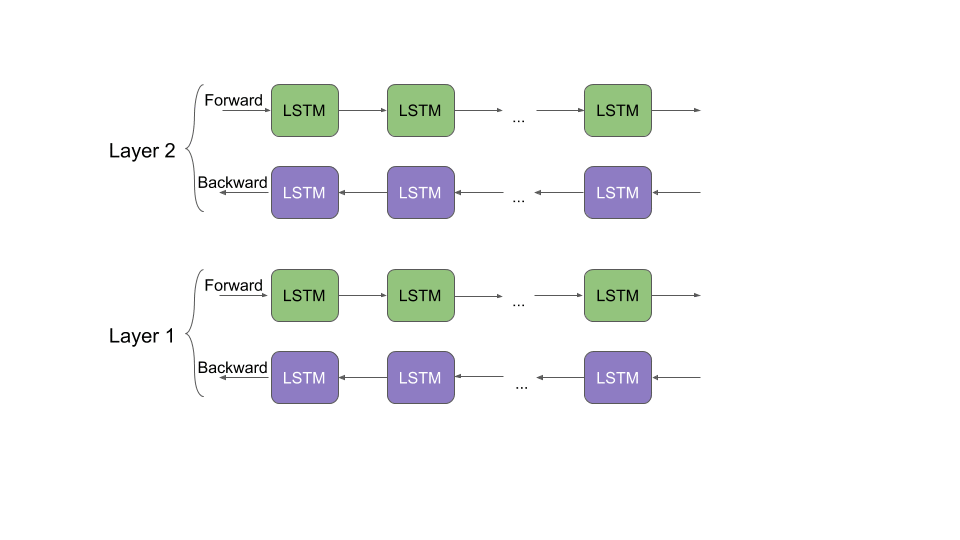

In [1]:
from IPython.display import Image
#Image(filename='local/imgs/ELMo.gif', width=1200)
Image(open('local/imgs/ELMo.gif','rb').read())

[Image taken from here](https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/)

Given $T$ tokens $(x_1,x_2,\cdots,x_T)$, a forward language model computes the probability of the sequence by modeling the probability of token $x_k$ given the history $(x_1,\cdots, x_{k-1})$. This formulation has been addressed in the state of the art using many different approach, and more recently including some approximation based on Bidirectional Recurrent Networks.

ELMo is inspired in the Language Modelling problem, which has the advantage of being a **self-supervised** task.

A practical implication of this difference is that we can use word2vec and Glove vectors trained on a large corpus directly for downstream tasks. All we need is the vectors for the words. There is no need for the model itself that was used to train these vectors.

However, in the case of ELMo and BERT (we will see it in a forthcoming lecture), since they are context dependent, we need the model that was used to train the vectors even after training, since the models generate the vectors for a word based on context. [source](https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe).

#### Let's see how to define a simplified ELMo version from scratch:

In [48]:
from keras import layers

class Highway(layers.Layer):
    def __init__(self, size, n_layers=2, **kwargs):
        super().__init__(**kwargs)
        self.n_layers = n_layers
        self.transforms = [layers.Dense(size, activation="relu") for _ in range(n_layers)]
        self.gates = [layers.Dense(size, activation="sigmoid") for _ in range(n_layers)]

    def call(self, x):
        # x: (..., size)
        for t, g in zip(self.transforms, self.gates):
            h = t(x)
            gate = g(x)
            x = gate * h + (1.0 - gate) * x
        return x

class CharCNNEmbedder(layers.Layer):
    """
    Char-CNN token embedder.
    Input: (batch, seq_len, char_len) integer indices
    Output: (batch, seq_len, token_emb_dim)
    """
    def __init__(self,
                 n_chars,
                 char_emb_dim=16,
                 token_emb_dim=512,
                 kernel_filters=None,
                 max_characters_per_token=50,
                 dropout=0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.char_embedding = layers.Embedding(input_dim=n_chars, output_dim=char_emb_dim, mask_zero=True)
        self.max_characters_per_token = max_characters_per_token
        self.dropout = layers.Dropout(dropout)

        if kernel_filters is None:
            # (kernel_size, n_filters)
            kernel_filters = [(1, 50), (2, 100), (3, 150), (4, 200)]

        self.convs = []
        total_filters = 0
        for k, f in kernel_filters:
            # Conv1D expects (batch, steps, channels) with channels last
            self.convs.append(layers.Conv1D(filters=f, kernel_size=k, padding="valid", activation="relu"))
            total_filters += f

        self.highway = Highway(total_filters, n_layers=2)
        self.proj = layers.Dense(token_emb_dim)

    def call(self, token_chars):
        # token_chars: (batch, seq_len, char_len)
        b, s, c = tf.shape(token_chars)[0], tf.shape(token_chars)[1], tf.shape(token_chars)[2]

        # Flatten tokens: (batch*seq_len, char_len)
        flat = tf.reshape(token_chars, [-1, tf.shape(token_chars)[2]])  # (B*S, C)

        # Char embedding -> (B*S, C, char_emb)
        emb = self.char_embedding(flat)

        # Apply convs: Conv1D over char sequence dimension (C)
        conv_outs = []
        for conv in self.convs:
            z = conv(emb)             # (B*S, C', filters)
            # global max pool over time dimension
            z = tf.reduce_max(z, axis=1)  # (B*S, filters)
            conv_outs.append(z)

        z = tf.concat(conv_outs, axis=-1)  # (B*S, total_filters)
        z = self.highway(z)
        z = self.proj(z)                    # (B*S, token_emb_dim)
        z = self.dropout(z)

        # reshape back to (batch, seq_len, token_emb_dim)
        out = tf.reshape(z, [b, s, tf.shape(z)[-1]])
        return out

We can also use pre-trained ELMo from tensorflow hub repository.

## Download the model

Let's load ELMo model. This will take some time because the model is over 350 Mb in size

In [2]:
import tensorflow_hub as hub
import tensorflow as tf

/Users/jdariasl/.cache/uv/archive-v0/mTE5xBvw1heDpxC7T3_--/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/2",
                     input_shape=[],  # string input
                     dtype=tf.string,
                     trainable=False,
                     signature="default",
                     output_key="elmo")  # or as needed

embeddings = elmo(tf.constant(["i like green eggs and ham",
                   "would you eat them in a box"]))

In [4]:
print(embeddings.shape)

(2, 7, 1024)


Unfortunately, the `tensorflow_hub` implementation of ELMo is not compatible with `tf2`, so we will train a simplified version from scratch.

## Name Entity Recognition (NER)

NER is a sequential labeling problem where the aim is to label every word in a sentence of pargraph, according to a list of "entity" classes. This is different from part of Speech (POS) tagging, which explains how a word is used in a sentence [For more information about POS](https://medium.com/greyatom/learning-pos-tagging-chunking-in-nlp-85f7f811a8cb). 

Tipical labels in NER are:

In [5]:
import nltk
# download necessary data
nltk.download("maxent_ne_chunker")
nltk.download("words")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jdariasl/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/jdariasl/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jdariasl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jdariasl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/jdariasl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/jdariasl/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!


True

GPE stands for Geo-Political Entity, GSP stands for Geographical-Social-Political Entity. and there are other definitions of labels that include more classes [Detailed info can be found here](https://www.ldc.upenn.edu/sites/www.ldc.upenn.edu/files/english-entities-guidelines-v6.6.pdf). 

NER task is commonly viewed as a sequential prediction problem in which we aim at assigning the correct label for each token. Different ways of encoding information in a set of labels make different chunk representation. The two most popular schemes are BIO and BILOU [source](https://natural-language-understanding.fandom.com/wiki/Named_entity_recognition).

- BIO stands for Beginning, Inside and Outside (of a text segment).
- Similar but more detailed than BIO, BILOU encode the Beginning, the Inside and Last token of multi-token chunks while differentiate them from Unit-length chunks

In [6]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = pd.read_csv("local/data/ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.ffill()
data.tail(12)

,Sentence #,Word,Tag
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O


In [7]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35178

In [8]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [9]:
tags

['B-geo',
 'B-org',
 'B-art',
 'I-geo',
 'B-tim',
 'I-per',
 'B-gpe',
 'B-eve',
 'I-org',
 'B-per',
 'I-eve',
 'O',
 'B-nat',
 'I-art',
 'I-gpe',
 'I-nat',
 'I-tim']

In [10]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        # Exclude grouping column when applying
        self.grouped = (
            self.data
            .drop(columns=["Sentence #"])      # removes grouping column
            .groupby(self.data["Sentence #"], group_keys=False)
            .apply(agg_func)
        )
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        if self.n_sent <= len(self.sentences):
            s = self.sentences[self.n_sent - 1]
            self.n_sent += 1
            return s
        else:
            return None

In [11]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [12]:
sentences = getter.sentences
print(len(sentences))

47959


In [13]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


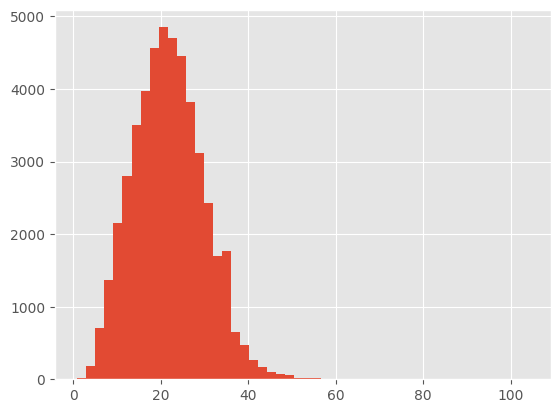

In [14]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [15]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

31915
0


ELMo embedding represents every word as 1024 feature vector; however, we will use a 128 embedding dimension in our implementation. Therefore, to reduce computational complexity and based on the former histogram, we can truncate the sequences to a maximum length of 50.

In [16]:
max_len = 50

In [41]:
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [42]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([ 6, 11, 11,  9,  5,  5,  5, 11, 11, 11, 11, 11,  4, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype=int32)

In [67]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [49]:
from keras.models import Model

## Excercise 1: Complete the model arquitecture

After the Embedding layer include two Bidirectional LSTM layers with 512 cells each. The second layer must be on top of the first one. As output layer include a Dense layer which takes as input the sum of the two Bidirectional layers output's. Remember that in NER the output must be a sequence of same length  as the input.

In [51]:
chars = ["<pad>"] + list("abcdefghijklmnopqrstuvwxyz.,!?-") + ["<unk>"]
char2idx = {c: i for i, c in enumerate(chars)}
n_chars = len(chars)

def sentences_to_char_ids(sentences, max_chars=16):
    """
    sentences: list of list of tokens, e.g. [["I","love","NLP"], ["this","is","ok"]]
    returns: np.array shape (batch, seq_len, max_chars)
    """
    batch = []
    max_len = max(len(s) for s in sentences)
    for tokens in sentences:
        token_chars = []
        for tok in tokens:
            tok = tok.lower()
            chars_idx = [char2idx.get(ch, char2idx["<unk>"]) for ch in tok][:max_chars]
            # pad char seq
            pad = [char2idx["<pad>"]] * (max_chars - len(chars_idx))
            token_chars.append(chars_idx + pad)
        # pad tokens to max_len
        for _ in range(max_len - len(tokens)):
            token_chars.append([char2idx["<pad>"]] * max_chars)
        batch.append(token_chars)
    return np.array(batch, dtype=np.int32)

In [60]:

class SimpleElmo(Model):
    def __init__(self,
                 n_chars,
                 n_tags,
                 char_emb_dim=16,
                 token_emb_dim=256,
                 lstm_hidden=256,
                 kernel_filters=None,
                 max_characters_per_token=50,
                 dropout=0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.char_encoder = CharCNNEmbedder(
            n_chars=n_chars,
            char_emb_dim=char_emb_dim,
            token_emb_dim=token_emb_dim,
            kernel_filters=kernel_filters,
            max_characters_per_token=max_characters_per_token,
            dropout=dropout
        )
        # project token embedding into same dim as BiLSTM output if needed
        self.token_proj = layers.Dense(2 * lstm_hidden) if token_emb_dim != 2 * lstm_hidden else None

        self.bilm1 = layers.Bidirectional(layers.LSTM(units=lstm_hidden, return_sequences=True,
                       recurrent_dropout=dropout, dropout=dropout))
        self.bilm2 = layers.Bidirectional(layers.LSTM(units=lstm_hidden, return_sequences=True,
                           recurrent_dropout=dropout, dropout=dropout))

        self.out = layers.TimeDistributed(Dense(n_tags, activation="softmax"))

    def call(self, token_chars, training=False, return_all_layers=False):
        """
        token_chars: (batch, seq_len, char_len) int32
        return_all_layers: if True return list [layer0_proj, layer1_out, ...]
        else return mixed embeddings (batch, seq_len, dim)
        """
        # 1) char-CNN token embeddings
        token_emb = self.char_encoder(token_chars, training=training)  # (batch, seq_len, token_emb_dim)

        # 2) optionally project to BiLSTM expected dim
        if self.token_proj is not None:
            token_proj = self.token_proj(token_emb)  # (batch, seq_len, 2*lstm_hidden)
        else:
            token_proj = token_emb

        # 3) BiLM stacked outputs
        layer_outputs = self.bilm1(token_proj)  # list of (batch, seq_len, 2*lstm_hidden)
        layer_outputs2 = self.bilm2(token_proj)  # list of (batch, seq_len, 2*lstm_hidden)
        
        # prepare list to mix: [token_proj, layer1, layer2, ...]
        mix = layer_outputs + layer_outputs2

        return self.out(mix)


model = SimpleElmo(n_chars=n_chars,
                   n_tags = n_tags,
                   token_emb_dim=128,
                   lstm_hidden=128,
                   dropout=0.1)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Split data into training and validation subsets, use both during training to evaluate training and validation accuracies.

In [68]:
batch_size = 32
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

Train the model using a batch_size = 32 and 5 epochs. Use verbose=1 to see the evolution of the training process.

In [69]:
Xtr_c = sentences_to_char_ids(X_tr, max_chars=16)  # (batch, seq_len, char_len)
Xval_c = sentences_to_char_ids(X_val, max_chars=16)  # (batch, seq_len, char_len)
model.fit(Xtr_c, y_tr, validation_data=(Xval_c, y_val),
                    batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 143s 118ms/step - accuracy: 0.9534 - loss: 0.1753 - val_accuracy: 0.9741 - val_loss: 0.0913
Epoch 2/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 177s 146ms/step - accuracy: 0.9753 - loss: 0.0861 - val_accuracy: 0.9791 - val_loss: 0.0720
Epoch 3/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 184s 152ms/step - accuracy: 0.9791 - loss: 0.0713 - val_accuracy: 0.9809 - val_loss: 0.0645
Epoch 4/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 1124s 928ms/step - accuracy: 0.9806 - loss: 0.0642 - val_accuracy: 0.9818 - val_loss: 0.0621
Epoch 5/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 23985s 20s/step - accuracy: 0.9821 - loss: 0.0577 - val_accuracy: 0.9824 - val_loss: 0.0579


In [ ]:
#!uv add seqeval
#!pip install seqeval

In [72]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
X_te_c = sentences_to_char_ids(X_te, max_chars=16)  # (batch, seq_len, char_len)
test_pred = model.predict(X_te_c, verbose=1)

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


In [73]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])

In [74]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 78.1%


**Note** that a pre-trained ELMo would achieve a F1-score of around 82\%

In [79]:
print(classification_report(test_labels, pred_labels, zero_division=0))

              precision    recall  f1-score   support

         art       0.00      0.00      0.00        49
         eve       0.24      0.24      0.24        33
         geo       0.81      0.86      0.84      3720
         gpe       0.93      0.94      0.94      1591
         nat       0.58      0.32      0.41        22
         org       0.64      0.48      0.55      2061
         per       0.68      0.73      0.71      1677
         tim       0.87      0.82      0.84      2148

   micro avg       0.79      0.77      0.78     11301
   macro avg       0.60      0.55      0.57     11301
weighted avg       0.78      0.77      0.77     11301



Let's see the predictions for one sequence:

In [76]:
i = 390
p = model.predict(X_te_c[i:i+batch_size])[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Word            Pred : (True)
Citing         :O     (O)
a              :O     (O)
draft          :O     (O)
report         :O     (O)
from           :O     (O)
the            :O     (O)
U.S.           :B-geo (B-org)
Government     :O     (I-org)
Accountability :O     (O)
office         :O     (O)
,              :O     (O)
The            :O     (B-org)
New            :B-org (I-org)
York           :I-org (I-org)
Times          :I-org (I-org)
said           :O     (O)
Saturday       :B-tim (B-tim)
the            :O     (O)
losses         :O     (O)
amount         :O     (O)
to             :O     (O)
between        :O     (O)
1,00,000       :O     (O)
and            :O     (O)
3,00,000       :O     (O)
barrels        :O     (O)
a              :O     (O)
day            :O     (O)
of             :O     (O)
Iraq           :B-geo (B-geo)
's             :O     (O)
declared       :O     (O)
oil            :O     (O)
production     :O     (O)
over           :

### Lest's compare the result with a simple Embedding layer instead of ELMo 

For the sake of comparison, create a model using a conventional Embedding layer, instead of ELMo model. We are going to use an output dimension of 128 for the Embedding layer and 10000 words dictionary for tokanization.

In [82]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        #agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]}
        self.in_grouped = self.data.groupby("Sentence #")["Word"].apply(lambda s: " ".join(s))
        self.out_grouped = self.data.groupby("Sentence #")["Tag"].apply(lambda s: " ".join(s))
        self.input_sentences = [s for s in self.in_grouped]
        self.output_targets = [s for s in self.out_grouped]
    
    def get_next(self):
        try:
            i = self.in_grouped["Sentence: {}".format(self.n_sent)]
            o = self.out_grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return i,o
        except:
            return None

In [83]:
getter = SentenceGetter(data)
sent_input, out_put = getter.get_next()

In [84]:
sentences = getter.input_sentences
targets = getter.output_targets
print(len(sentences))
print(len(targets))

47959
47959


In [85]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w] for w in s.split(' ')] for s in targets]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([ 6, 11, 11,  9,  5,  5,  5, 11, 11, 11, 11, 11,  4, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype=int32)

In [87]:
from tensorflow.keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer(num_words=10000)
# fit the tokenizer on the documents
word_tokenizer.fit_on_texts(sentences)

In [89]:
# summarize what was learned
#print(word_tokenizer.word_counts)
#print(word_tokenizer.document_count)
#print(word_tokenizer.word_index)
#print(word_tokenizer.word_docs)
# integer encode documents
encoded_docs = word_tokenizer.texts_to_sequences(sentences)
#print(encoded_docs)

In [90]:
len(encoded_docs[0])

23

In [91]:
NewX = pad_sequences(maxlen=max_len, sequences=encoded_docs, padding="post", value=0)
NewX[15]

array([ 110,   33,   26,   98,   56, 1649,  834,   32, 5699,    5,  780,
       3787,   76,    4,  543,    5, 4298, 6304,    2,   30, 1720, 1121,
         84, 1236,    8,    5, 3083, 2845, 1275,   52,   97,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [92]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(NewX, y, test_size=0.1, random_state=2018)

In [93]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [94]:
from keras.layers import Embedding

In [101]:
input_text = Input(shape=(max_len,))
embedding = Embedding(input_dim=10000, output_dim=128, mask_zero=True)(input_text)
# Complete the model architecture here:
x = Bidirectional(LSTM(units=128, return_sequences=True,
                       recurrent_dropout=0.1, dropout=0.1))(embedding)
x_rnn = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.1, dropout=0.1))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [102]:
model2 = Model(input_text, out)
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [103]:
model2.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.9332 - loss: 0.6521 - val_accuracy: 0.9498 - val_loss: 0.3776
Epoch 2/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 79s 65ms/step - accuracy: 0.9517 - loss: 0.3461 - val_accuracy: 0.9536 - val_loss: 0.3345
Epoch 3/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 88s 73ms/step - accuracy: 0.9563 - loss: 0.2946 - val_accuracy: 0.9555 - val_loss: 0.3173
Epoch 4/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 87s 72ms/step - accuracy: 0.9607 - loss: 0.2569 - val_accuracy: 0.9562 - val_loss: 0.3134
Epoch 5/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 89s 73ms/step - accuracy: 0.9639 - loss: 0.2304 - val_accuracy: 0.9563 - val_loss: 0.3200


In [104]:
X_te = X_te[:149*batch_size,:]
test_pred = model2.predict(np.array(X_te), verbose=1)

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [105]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])

In [106]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 51.5%


In [107]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         art       0.00      0.00      0.00        49
         eve       0.14      0.09      0.11        33
         geo       0.62      0.47      0.53      3720
         gpe       0.80      0.63      0.70      1591
         nat       0.20      0.23      0.21        22
         org       0.49      0.32      0.38      2061
         per       0.50      0.43      0.46      1677
         tim       0.63      0.45      0.52      2148

   micro avg       0.60      0.45      0.52     11301
   macro avg       0.42      0.33      0.37     11301
weighted avg       0.60      0.45      0.51     11301



<font color=red>**Note the performance drop in this case!**</font>

Let's see the predictions for the same sentenced analysed before:

In [108]:
i = 390
p = model2.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Word            Pred : (True)
           2327:O     (O)
              5:O     (O)
           1604:O     (O)
            144:O     (O)
             21:O     (O)
              1:O     (O)
             14:O     (B-org)
             20:B-org (I-org)
             34:I-org (O)
           8632:I-org (O)
            383:I-org (O)
              1:O     (B-org)
             49:B-org (I-org)
            436:I-org (I-org)
            784:I-org (I-org)
             16:I-org (O)
             95:B-tim (B-tim)
              1:O     (O)
           1890:O     (O)
           2436:O     (O)
              4:O     (O)
            109:O     (O)
            155:O     (O)
            583:O     (O)
             88:O     (O)
              6:O     (O)
            356:O     (O)
            583:O     (O)
             88:O     (O)
           1559:O     (B-geo)
              5:O     (O)
            125:O     (O)
              3:O     (O)
             60:O     (O)
              7: